# 神経サンプリング

サンプリングに基づく符号化(sampling-based coding; SBC or neural sampling model)をガウス尺度混合モデルを例にとり実装する．

## ガウス尺度混合モデル
**ガウス尺度混合 (Gaussian scale mixture; GSM) モデル**は確率的生成モデルの一種である{cite:p}`Wainwright1999-cl`{cite:p}`Orban2016-tm`．GSMモデルでは入力を次式で予測する：

$$
\begin{equation}
\text{入力}={z}\left(\sum \text{神経活動} \times \text{基底} \right) + \text{ノイズ}
\end{equation}
$$

前節までのスパース符号化モデル等と同様に，入力が基底の線形和で表されるとしている．ただし，尺度(scale)パラメータ$z$が基底の線形和に乗じられている点が異なる．\footnote{コードは{cite:p}`Orban2016-tm` <https://github.com/gergoorban/sampling_in_gsm>, および{cite:p}`Echeveste2020-sh` <https://bitbucket.org/RSE_1987/ssn_inference_numerical_experiments/src/master/>を参考に作成した．}


### 事前分布
$\mathbf{x} \in \mathbb{R}^{N_x}$, $\mathbf{A} \in \mathbb{R}^{N_x\times N_y}$, $\mathbf{y} \in \mathbb{R}^{N_y}$, $\mathbf{z} \in \mathbb{R}$とする．

$$
\begin{equation}
p\left(\mathbf{x}\mid\mathbf{y}, z\right)=\mathcal{N}\left(z \mathbf{A} \mathbf{y}, \sigma_{\mathbf{x}}^{2} \mathbf{I}\right)
\end{equation}
$$

事前分布を

$$
\begin{align}
p\left(\mathbf{y}\right)&=\mathcal{N}\left(\mathbf{0}, \mathbf{C}\right)\\
p\left(z\right)&=\Gamma (k, \vartheta)
\end{align}
$$

とする．$\Gamma(k, \vartheta)$はガンマ分布であり，$k$は形状(shape)パラメータ，$\vartheta$は尺度(scale)パラメータである．$p\left(\mathbf{y}\right)$は$\mathbf{y}$の事前分布であり，刺激がない場合の自発活動の分布を表していると仮定する．

### 重み行列$\mathbf{A}$の作成


In [1]:
using PyPlot, LinearAlgebra, Random, Distributions, KernelDensity, StatsBase
using PyPlot: matplotlib
Random.seed!(0)
rc("axes.spines", top=false, right=false)

In [2]:
function gabor(x, y, θ, σ=1, λ=2, ψ=0)
    xθ = x * cos(θ) + y * sin(θ)
    yθ = -x * sin(θ) + y * cos(θ)
    return exp(-.5(xθ^2 + yθ^2)/σ^2) * cos(2π/λ * xθ + ψ)
end;

In [3]:
function get_A(WH, Ny)
    Nx = WH^2
    A = zeros(Nx, Ny) # weight matrix
    p = range(-3, 3, length=WH) # position
    θ = (1:Ny) / Ny * π # theta for gabor
    for i in 1:Ny
        gb = gabor.(p', p, θ[i])
        gb /= norm(gb) + 1e-8 # normalization
        A[:, i] = gb[:] # flatten and save
    end
    return A
end;

In [4]:
WH = 16   # width/height of input image
Nx = WH^2 # dimension of the observed variable x
Ny = 50  # dimension of the hidden variable y

A = get_A(WH, Ny);

重み行列$\mathbf{A}$の一部を描画してみよう．

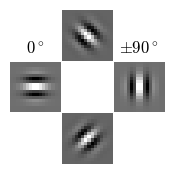

In [65]:
figure(figsize=(2,2))
plot_idx = [2,4,6,8]
weight_idx = [37,25,50,13]
titles = ["", L"$0^\circ$", L"$\pm 90^\circ$", ""]
for i in 1:4
    subplot(3,3,plot_idx[i])
    title(titles[i], math_fontfamily="cm")
    imshow(reshape(A[:, weight_idx[i]], WH, WH), cmap="gray")
    axis("off")
end
subplots_adjust(wspace=0.01, hspace=0.01)

### 分散共分散行列$\mathbf{C}$の作成
$\mathbf{C}$は$y$の事前分布の分散共分散行列である．{cite:p}`Orban2016-tm`では自然画像を用いて作成しているが，ここでは簡単のため$\mathbf{A}$と同様に{cite:p}`Echeveste2020-sh`に従って作成する．前項で作成した通り，$\mathbf{A}$の各基底には周期性があるため，類似した基底を持つニューロン同士は類似した出力をすると考えられる．Echevesteらは$\theta\in[-\pi/2, \pi/2)$の範囲においてFourier基底を複数作成し，そのグラム行列(Gram matrix)を係数倍したものを$\mathbf{C}$と設定している．ここではガウス過程(Gaussian process)モデルとの類似性から，周期カーネル(periodic kernel) 

$$
\begin{equation}
K(\theta, \theta')=\exp\left[\phi_1 \cos \left(\dfrac{|\theta-\theta'|}{\phi_2}\right)\right]
\end{equation}
$$

を用いる．ここでは$|\theta-\theta'|=m\pi\ (m=0,1,\ldots)$の際に類似度が最大になればよいので，$\phi_2=0.5$とする．これが正定値行列になるように単位行列の係数倍$\epsilon\mathbf{I}$を加算し，スケーリングした上で，`Symmetric(C)`や`Matrix(Hermitian(C)))`により実対象行列としたものを$\mathbf{C}$とする．$\mathbf{C}$を正定値行列にする理由はJuliaの`MvNormal`がCholesky分解を用いて多変量正規分布の乱数を生成するためである． 事前に`cholesky(C)`が実行できるか確認するのもよい．

In [6]:
function get_C(Ny, C_range=[-0.5, 4.0], eps=0.1, ψ₁=2.0, ψ₂=0.5)
    K(x₁, x₂, ψ₁, ψ₂) = exp(ψ₁ * cos(abs(x₁-x₂) / ψ₂)) # periodic kernel
    θ = (1:Ny) / Ny * π # theta for gabor
    C = K.(θ', θ, ψ₁, ψ₂) # create covariance matrix
    C += eps * I # regularization to make C positive definite
    C_min, C_max = minimum(C), maximum(C)
    C = C_range[1] .+ (C_range[2]-C_range[1]) * (C .- C_min) / (C_max - C_min)
    return Symmetric(C); # make symmetric matrix using upper triangular matrix
end;

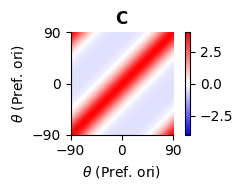

In [7]:
C = get_C(Ny)

figure(figsize=(3,2))
title(L"$\mathbf{C}$")
ims = imshow(C, origin="lower", cmap="bwr", vmin=-4, vmax=4, extent=(-90, 90, -90, 90))
xticks([-90,0,90]); yticks([-90,0,90]); 
xlabel(L"$\theta$ (Pref. ori)"); ylabel(L"$\theta$ (Pref. ori)")
colorbar(ims);
tight_layout()

ここでPref. oriは最適方位 (preferred orientation)を意味する．

### 事後分布の計算
事後分布は$z$と$\mathbf{y}$のそれぞれについて次のように求められる．


$$
\begin{align}
p(z \mid \mathbf{x}) &\propto p(z) \mathcal{N}\left(0, z^{2} \mathbf{A C A}^{\top}+\sigma_{x}^{2} \mathbf{I}\right)\\
p(\mathbf{y} \mid z, \mathbf{x})& = \mathcal{N}\left(\mu(z, \mathbf{x}), \Sigma(z)\right)
\end{align}
$$

ただし，

$$
\begin{align}
\Sigma(z)&=\left(\mathbf{C}^{-1}+\frac{z^{2}}{\sigma_{x}^{2}} \mathbf{A}^{\top} \mathbf{A}\right)^{-1}\\
\mu(z, \mathbf{x})&=\frac{z}{\sigma_{x}^{2}} \Sigma(z) \mathbf{A}^{\top} \mathbf{x}
\end{align}
$$

である．

最終的な予測において$z$の事後分布は必要でないため，$p(\mathbf{y} \mid z, \mathbf{x})$から$z$を消去することを考えよう．厳密に行う場合，次式のように周辺化(marginalization)により，$z$を（積分）消去する必要がある．

$$
\begin{equation}
p(\mathbf{y} \mid \mathbf{x}) = \int dz\ p(z\mid \mathbf{x})\cdot p(\mathbf{y} \mid z, \mathbf{x})
\end{equation}
$$

周辺化においては，まず$z$のMAP推定（最大事後確率推定）値 $z_{\mathrm{MAP}}$を求める．

$$
\begin{equation}
z_{\mathrm{MAP}} = \underset{z}{\operatorname{argmax}} p(z\mid \mathbf{x})
\end{equation}
$$

次に$z_{\mathrm{MAP}}$の周辺で$p(z\mid \mathbf{x})$を積分し，積分値が一定の閾値を超える$z$の範囲を求め，この範囲で$z$を積分消去してやればよい．しかし，$z$は単一のスカラー値であり，この手法で推定するのは煩雑であるために近似手法が{cite:p}`Echeveste2017-wu`において提案されている．Echevesteらは第一の近似として，$z$の分布を$z_{\mathrm{MAP}}$でのデルタ関数に置き換える，すなわち，$p(z\mid \mathbf{x})\simeq \delta (z-z_{\mathrm{MAP}})$とすることを提案している．この場合，$z$は定数とみなせ，$p(\mathbf{y} \mid \mathbf{x})\simeq p(\mathbf{y} \mid \mathbf{x}, z=z_{\mathrm{MAP}})$となる．第二の近似として，$z_{\mathrm{MAP}}$を真のコントラスト$z^*$で置き換えることが提案されている．GSMへの入力$\mathbf{x}$は元の画像を$\mathbf{\tilde x}$とすると，$\mathbf{x}=z^* \mathbf{\tilde x}$としてスケーリングされる．この入力の前処理の際に用いる$z^*$を用いてしまおうということである．この場合，$p(\mathbf{y} \mid \mathbf{x})\simeq p(\mathbf{y} \mid \mathbf{x}, z=z^*)$となる．しかし，入力を任意の画像とする場合，$z^*$は未知である．簡便さと精度のバランスを取り，ここでは第一の近似，$z=z_{\mathrm{MAP}}$とする手法を用いることにする．

In [8]:
# log pdf of p(z)
log_Pz(z, k, θ) = logpdf.(Gamma(k, θ), z)

# pdf of p(z|x)
function Pz_x(z_range, x, ACAᵀ, σₓ², k, θ)
    n_contrasts = length(z_range)
    log_p = zeros(n_contrasts)
    μxz = zeros(size(x))
    dz = z_range[2] - z_range[1]
    for i in 1:n_contrasts
        Cxz = z_range[i]^2 * ACAᵀ + σₓ² * I
        log_p[i] = log_Pz(z_range[i], k, θ) + logpdf(MvNormal(μxz, Symmetric(Cxz)), x)
    end
    p = exp.(log_p .- maximum(log_p)) # for numerical stability
    p /= sum(p) * dz
    return p
end;

In [9]:
# mean and covariance matrix of p(y|x, z)
function post_moments(x, z, σₓ², A, AᵀA, C⁻¹)
    Σz = inv(C⁻¹ + (z^2 / σₓ²) * AᵀA)
    μzx = (z/σₓ²) * Σz * A' * x
    return μzx, Σz
end;

### シミュレーション


In [10]:
AᵀA = A' * A
ACAᵀ = A * C * A'

σₓ = 1.0 # Noise of the x process
σₓ² = σₓ^2
k, θ = 2.0, 2.0 # Parameter of the gamma dist. for z (Shape, Scale)

C⁻¹ = inv(C); # inverse of C

入力データの作成

In [11]:
Z = [0.0, 0.25, 0.5, 1.0, 2.0] # true contrasts z^*
n_samples = size(Z)[1]
y = rand(MvNormal(zeros(Ny), C), 1) # sampling from P(y)=N(0, C)
X = stack([rand(MvNormal(vec(z*A*y), σₓ*I)) for z in Z])';

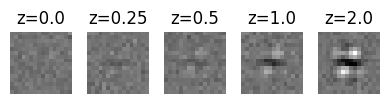

In [70]:
x_min, x_max = minimum(X), maximum(X)

figure(figsize=(4,2))
for s in 1:n_samples
    subplot(1, n_samples, s)
    title("z=$(Z[s])")
    imshow(reshape(X[s, :], WH, WH), vmin=x_min, vmax=x_max, cmap="gray")
    axis("off")
end
tight_layout()

事後分布の計算をする．

In [13]:
μ_post = zeros(n_samples, Ny)
σ_post = zeros(n_samples, Ny)
Σ_post = zeros(n_samples, Ny, Ny)

z_range = range(0, 5.0, length=100) # range of z for MAP estimation
Z_MAP = zeros(n_samples) 

for s in 1:n_samples
    p_z = Pz_x(z_range, X[s, :], ACAᵀ, σₓ², k, θ)
    Z_MAP[s] = z_range[argmax(p_z)] # MAP estimated z
    μ_post[s, :], Σ_post[s, :, :] = post_moments(X[s, :], Z_MAP[s], σₓ², A, AᵀA, C⁻¹)
    σ_post[s, :] = sqrt.(diag(Σ_post[s, :, :]))
end

結果

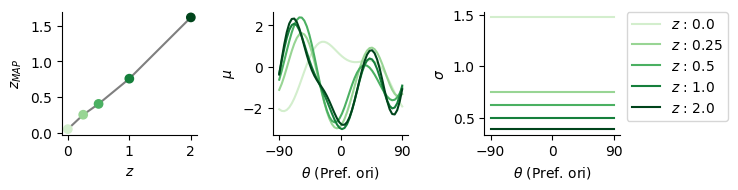

In [14]:
θs = range(-90, 90, length=Ny)
cm = get_cmap(:Greens) # get color map
cms = cm.((1:n_samples)/n_samples) # color list

fig, ax = subplots(1, 3, figsize=(7.5, 2))
ax[1].scatter(Z, Z_MAP, c=cms)
ax[1].plot(Z, Z_MAP, color="tab:gray", zorder=0)
ax[1].set_xlabel(L"$z$"); ax[1].set_ylabel(L"$z_{MAP}$"); 
for s in 1:n_samples
    ax[2].plot(θs, μ_post[s, :], color=cms[s])
    ax[3].plot(θs, σ_post[s, :], color=cms[s], label=L"$z$ : "*string(Z[s]))
end
ax[2].set_ylabel(L"$\mu$"); ax[3].set_ylabel(L"$\sigma$")
for i in 2:3
    ax[i].set_xticks([-90,0,90])
    ax[i].set_xlabel(L"$\theta$ (Pref. ori)")
end
ax[3].legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
tight_layout()

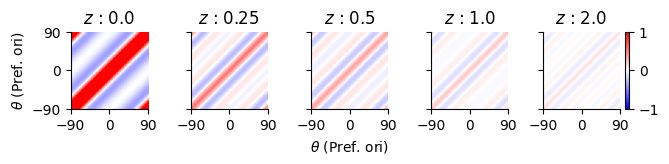

In [15]:
fig, ax = subplots(1, n_samples, figsize=(7.5, 1), sharex="all", sharey="all")
for s in 1:n_samples
    ax[s].set_title(L"$z$ : "*string(Z[s]))
    ims = ax[s].imshow(Σ_post[s, :, :], origin="lower", cmap="bwr", extent=(-90, 90, -90, 90), vmin=-1, vmax=1)
    ax[s].set_xticks([-90,0,90]); ax[s].set_yticks([-90,0,90]);
    if s == 1
        ax[s].set_ylabel(L"$\theta$ (Pref. ori)")
    elseif s == ceil(Int, n_samples/2) 
        ax[s].set_xlabel(L"$\theta$ (Pref. ori)"); 
    end
end
fig.colorbar(ims, ax=ax[n_samples]);

出力のサンプリングを行う．

In [16]:
membrane_potential(y, α=2.4, β=1.9, γ=0.6) = α * max(0, y+β)^γ

membrane_potential (generic function with 4 methods)

事後分布から応答をサンプリングする．

In [17]:
nt = 1000
h_gsm = zeros(n_samples, Ny, nt)
for s in 1:n_samples
    μ = μ_post[s, :]
    Σ = Σ_post[s, :, :]
    sample = rand(MvNormal(μ, Symmetric(Σ)), nt)
    h_gsm[s, :, :] = membrane_potential.(sample)
end

In [18]:
# modified from https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html
function confidence_ellipse(x, y, ax, n_std=3, alpha=1, facecolor="none", edgecolor="tab:gray")
    pearson = cor(x,y)
    rx, ry = sqrt(1 + pearson), sqrt(1 - pearson)
    ellipse = matplotlib.patches.Ellipse((0, 0), width=2*rx, height=2*ry, alpha=alpha, 
        fc=facecolor, ec=edgecolor, lw=2, zorder=0)
    scales = [std(x), std(y)] * n_std
    means = [mean(x), mean(y)]
    transf = matplotlib.transforms.Affine2D().rotate_deg(45).scale(scales...).translate(means...)
    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)
end;

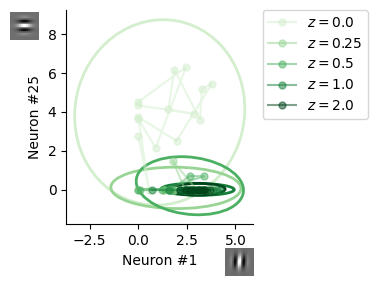

In [19]:
fig, ax = subplots(figsize=(4, 3))
unit_idx = [1, 25]
for s in 1:n_samples
    h₁, h₂ = h_gsm[s, unit_idx[1], :], h_gsm[s, unit_idx[2], :]
    ax.plot(h₁[1:15], h₂[1:15], marker="o", markersize=5, alpha=0.5, color=cms[s], label=L"$z=$"*string(Z[s]))
    confidence_ellipse(h₁, h₂, ax, 3, 1, "none", cms[s])
end
ax.set_xlabel("Neuron #"*string(unit_idx[1])); ax.set_ylabel("Neuron #"*string(unit_idx[2]))
axins = [ax.inset_axes([0.85, -0.25,0.15,0.15]), ax.inset_axes([-0.3,0.85,0.15,0.15])]
for i in 1:2
    axins[i].imshow(reshape(A[:,unit_idx[i]], WH, WH), cmap="gray")
    axins[i].axis("off")
end
ax.set_aspect("equal", "box")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
tight_layout()

## 興奮性・抑制性神経回路によるサンプリング
前節で実装したMCMCを**興奮性・抑制性神経回路 (excitatory-inhibitory (E-I) network)** で実装する．HMCとLMCの両方を神経回路で実装する．ハミルトニアンを用いる場合，一般化座標$\mathbf{q}$を興奮性神経細胞の活動$\mathbf{u}$, 一般化運動量$\mathbf{p}$を抑制性神経細胞の活動$\mathbf{v}$に対応させる．$\mathbf{u,\ v}$は同じ次元のベクトルとする．$\mathbf{u}, \mathbf{v}$の時間発展はハミルトニアン$\mathcal{H}$を導入して

$$
\begin{equation}
\tau\frac{d\mathbf{u}}{dt} = \frac{\partial \mathcal{H}}{\partial\mathbf{v}},\quad\tau\frac{d\mathbf{v}}{dt} = - \frac{\partial \mathcal{H}}{\partial\mathbf{u}}
\end{equation}
$$

と書ける．一般的には$\mathcal{H}(\mathbf{u}, \mathbf{v}) = E\left( \mathbf{u} \right) + \frac{1}{2}\mathbf{v}^{\top}\mathbf{v}$であり，$p\left( \mathbf{u},\ \mathbf{v} \right) \propto \exp( - \mathcal{H}(\mathbf{u,v}))$である．力学的エネルギーを保つ運動は，対数同時分布における等値線上の運動と同じである．

\citep{Aitchison2016-xu}では

$$
\begin{equation}
\mathcal{H}(\mathbf{u}, \mathbf{v}) = \log p \left(\mathbf{u}, \mathbf{v} \right) + \textrm{Const.} = \log p \left(\mathbf{v} \middle| \mathbf{u} \right) + \log p\left(\mathbf{u} \right) + \textrm{Const.}
\end{equation}
$$

とし，$p\left( \mathbf{v} \middle| \mathbf{u} \right)\mathcal{= N}\left( \mathbf{v};\mathbf{Bu},\ \mathbf{M}^{- 1} \right),\ \ p\left( \mathbf{u} \right) = \mathcal{N\ (}\mathbf{0},\ \mathbf{C}^{- 1})$としている．この場合，

$$
\begin{align}
\frac{d\mathbf{u}}{dt} &= \frac{1}{\tau}\frac{\partial \mathcal{H}}{\partial\mathbf{v}} = \frac{1}{\tau}\frac{\partial\log{p\left( \mathbf{u},\ \mathbf{v} \right)}}{\partial\mathbf{v}} = \ \frac{1}{\tau}\frac{\partial\log{p\left( \mathbf{v} \middle| \mathbf{u} \right)}}{\partial\mathbf{v}}\\
\frac{d\mathbf{v}}{dt} &= - \frac{1}{\tau}\frac{\partial \mathcal{H}}{\partial\mathbf{u}} = - \frac{1}{\tau}\frac{\partial\log{p\left( \mathbf{u},\ \mathbf{v} \right)}}{\partial\mathbf{u}} = \  - \frac{1}{\tau}\frac{\partial\log{p\left( \mathbf{v} \middle| \mathbf{u} \right)}}{\partial\mathbf{u}} - \frac{1}{\tau}\frac{\partial\log{p\left( \mathbf{u} \right)}}{\partial\mathbf{u}}
\end{align}
$$
となる．このままでは等値線上を運動することになるので，Langevinダイナミクスを付け加える．

$$
\begin{align}
\frac{d\mathbf{u}}{dt} &= \frac{1}{\tau}\frac{\partial\log{p\left( \mathbf{v} \middle| \mathbf{u} \right)}}{\partial\mathbf{v}} + \frac{1}{\tau_{L}}\frac{\partial\log{p\left( \mathbf{u},\ \mathbf{v} \right)}}{\partial\mathbf{u}} + \sqrt{\frac{2}{\tau_{L}}}\ d\eta\\
&= \frac{1}{\tau}\frac{\partial\log{p\left( \mathbf{v} \middle| \mathbf{u} \right)}}{\partial\mathbf{v}} + \frac{1}{\tau_{L}}\frac{\partial\log{p\left( \mathbf{v|u} \right)}}{\partial\mathbf{u}} + \frac{1}{\tau_{L}}\frac{\partial\log{p\left( \mathbf{u} \right)}}{\partial\mathbf{u}} + \sqrt{\frac{2}{\tau_{L}}}\ d\eta\\
\frac{d\mathbf{v}}{dt} &= - \frac{1}{\tau}\frac{\partial\log{p\left( \mathbf{v} \middle| \mathbf{u} \right)}}{\partial\mathbf{u}} - \frac{1}{\tau}\frac{\partial\log{p\left( \mathbf{u} \right)}}{\partial\mathbf{u}} + \frac{1}{\tau_{L}}\frac{\partial\log{p\left( \mathbf{u},\mathbf{v} \right)}}{\partial\mathbf{v}} + \sqrt{\frac{2}{\tau_{L}}}\ d\eta\\
&= - \frac{1}{\tau}\frac{\partial\log{p\left( \mathbf{v} \middle| \mathbf{u} \right)}}{\partial\mathbf{u}} + \frac{1}{\tau_{L}}\frac{\partial\log{p\left( \mathbf{v|u} \right)}}{\partial\mathbf{v}} - \frac{1}{\tau}\frac{\partial\log{p\left( \mathbf{u} \right)}}{\partial\mathbf{u}} + \sqrt{\frac{2}{\tau_{L}}}\ d\eta
\end{align}
$$

となる．それぞれの項は

$$
\begin{align}
\frac{\partial\log{p\left( \mathbf{v} \middle| \mathbf{u} \right)}}{\partial\mathbf{v}} &= \mathbf{B}^{\top}\mathbf{M}\left( \mathbf{Bu} - \mathbf{v} \right)\\
\frac{\partial\log{p\left( \mathbf{v} \middle| \mathbf{u} \right)}}{\partial\mathbf{u}} &= - \mathbf{M}\left( \mathbf{Bu} - \mathbf{v} \right)\\
\frac{\partial\log{p\left( \mathbf{u} \right)}}{\partial\mathbf{u}} &= - \mathbf{Cu}
\end{align}
$$

であるので，

$$
\begin{align}
\frac{d\mathbf{u}}{dt} &= \frac{1}{\tau}\mathbf{B}^{\top}\mathbf{M}\left( \mathbf{Bu} - \mathbf{v} \right) - \frac{1}{\tau_{L}}\mathbf{M}\left( \mathbf{Bu} - \mathbf{v} \right) - \frac{1}{\tau_{L}}\mathbf{Cu} + \sqrt{\frac{2}{\tau_{L}}}\ d\eta\\
\frac{d\mathbf{v}}{dt} &= \frac{1}{\tau}\mathbf{M}\left( \mathbf{Bu} - \mathbf{v} \right) + \frac{1}{\tau_{L}}\mathbf{B}^{\top}\mathbf{M}\left( \mathbf{Bu} - \mathbf{v} \right) + \frac{1}{\tau}\mathbf{Cu} + \sqrt{\frac{2}{\tau_{L}}}\ d\eta
\end{align}
$$

となる．$\mathbf{B = I}$ とすると，

$$
\begin{align}
\frac{d\mathbf{u}}{dt} &= \frac{1}{\tau}\mathbf{M}\left( \mathbf{u} - \mathbf{v} \right) - \frac{1}{\tau_{L}}\mathbf{M}\left( \mathbf{u} - \mathbf{v} \right) - \frac{1}{\tau_{L}}\mathbf{Cu} + \sqrt{\frac{2}{\tau_{L}}}\ d\eta\\
&= \left\lbrack \left( \frac{1}{\tau} - \frac{1}{\tau_{L}} \right)\mathbf{M} - \frac{1}{\tau_{L}}\mathbf{C} \right\rbrack\mathbf{u} - \left( \frac{1}{\tau} - \frac{1}{\tau_{L}} \right)\mathbf{Mv} + \sqrt{\frac{2}{\tau_{L}}}\ d\eta\\
\frac{d\mathbf{v}}{dt} &= \frac{1}{\tau}\mathbf{M}\left( \mathbf{u} - \mathbf{v} \right) + \frac{1}{\tau_{L}}\mathbf{M}\left( \mathbf{u} - \mathbf{v} \right) + \frac{1}{\tau}\mathbf{Cu} + \sqrt{\frac{2}{\tau_{L}}}\ d\eta\\
&= \left\lbrack \left( \frac{1}{\tau} + \frac{1}{\tau_{L}} \right)\mathbf{M} + \frac{1}{\tau_{L}}\mathbf{C} \right\rbrack\mathbf{u} - \left( \frac{1}{\tau} + \frac{1}{\tau_{L}} \right)\mathbf{Mv} + \sqrt{\frac{2}{\tau_{L}}}\ d\eta
\end{align}
$$

となり，$\mathbf{u}\mathbf{,\ v}$と定行列およびノイズに依存してサンプリングダイナミクスを記述できる．長々と式変形を書いたが，重要なのは**興奮性・抑制性という2種類の細胞群の相互作用により生み出された振動を用いてサンプリングにおける自己相関を下げることができる**という点である．

簡単のため，前項で用いた入力刺激のうち，最も$z$が大きいサンプルのみを使用する．

In [54]:
dt = 1e-2 # ms
τ, τl = 10.0, 150.0 # ms
α_in = [1/τ - 1/τl, 1/τ + 1/τl]
α_ext = [1/τl, -1/τ]
ρ = sqrt(2*dt/τl);

nt = 200000
M = cat(ones(1,1), C; dims=(1,2));
#x_idx = n_samples # get last x
x = X[end-1, :]
u_init = [1; zeros(Ny)];

In [55]:
Z[end-1]

1.0

In [21]:
function ∇ᵤlogP(u, x, σₓ², A, C⁻¹)
    z, y = abs(u[1]), u[2:end]
    pred_error = A' * (x - z*A*y) / σₓ² # prediction error signal
    du = zeros(size(u))
    du[1] = sign(u[1]) * (y' * pred_error - z)
    du[2:end] = z * pred_error - C⁻¹*y
    return du
end

∇ᵤlogP (generic function with 1 method)

In [56]:
∇log_p(u) = ∇ᵤlogP(u, x, σₓ², A, C⁻¹);

In [23]:
function neural_lmc(∇log_p::Function, u_init::Vector{Float64}, α::Float64, ρ::Float64, dt::Float64, nt::Int)
    d = length(u_init)
    u = zeros(nt, d)
    u[1, :] = u_init

    for t in 1:nt-1
        I_ext = ∇log_p(u[t, :]) # external input
        u[t+1, :] = u[t, :] + dt * (α * I_ext) + ρ * randn(d) 
    end
    return u
end

function neural_hmc(∇log_p::Function, u_init::Vector{Float64}, M::Matrix{Float64}, 
        α_in::Vector{Float64}, α_ext::Vector{Float64}, ρ::Float64, dt::Float64, nt::Int)
    d = length(u_init)
    u, v = zeros(nt, d), zeros(nt, d)
    u[1, :] = u_init

    for t in 1:nt-1
        I_ext = ∇log_p(u[t, :]) # external input
        I_in = M * (u[t, :] - v[t, :]) # internal input
        u[t+1, :] = u[t, :] + dt * (α_in[1] * I_in + α_ext[1] * I_ext) + ρ * randn(d) 
        v[t+1, :] = v[t, :] + dt * (α_in[2] * I_in + α_ext[2] * I_ext) + ρ * randn(d)
    end
    return u, v
end;

In [57]:
@time u_nlmc = neural_lmc(∇log_p, u_init, α_ext[1], ρ, dt, nt);

  1.433021 seconds (3.20 M allocations: 2.180 GiB, 11.74% gc time)


In [58]:
@time u_nhmc, v_nhmc = neural_hmc(∇log_p, u_init, M, α_in, α_ext, ρ, dt, nt);

  2.272425 seconds (6.00 M allocations: 3.549 GiB, 15.58% gc time)


初めの100msはburn-in期間として除く．またダウンサンプリングする．

In [59]:
L = 100
burn_in = 10000
mcmc_time = (burn_in*dt):(L*dt):(nt*dt); # time for plot

In [60]:
mean_nlmc = mean(u_nlmc[burn_in:L:end, 2:end], dims=2); # pseudo-LFP
mean_nhmc = mean(u_nhmc[burn_in:L:end, 2:end], dims=2);

autocorr_nlmc = autocor(mean_nlmc, 1:length(mean_nlmc)-1);
autocorr_nhmc = autocor(mean_nhmc, 1:length(mean_nhmc)-1);

$z$の推定過程を描画する．また，$z$を除いた$\mathbf{u}$を平均化し，自己相関の度合いを確認する．

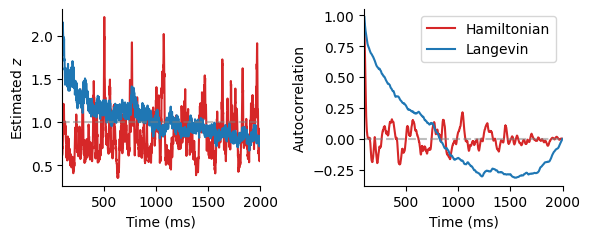

In [61]:
fig, ax = subplots(1,2,figsize=(6,2.5),sharex="all")
ax[1].plot(mcmc_time, u_nhmc[burn_in:L:end, 1], color="tab:red")
ax[1].plot(mcmc_time, u_nlmc[burn_in:L:end, 1], color="tab:blue")
ax[1].axhline(Z[x_idx-1], linestyle="dashed", color="tab:gray", alpha=0.5)
ax[1].set_xlabel("Time (ms)"); ax[1].set_ylabel(L"Estimated $z$")
ax[1].set_xlim(mcmc_time[1], mcmc_time[end])

ax[2].plot(mcmc_time[1:end-1], autocorr_nhmc, color="tab:red", label="Hamiltonian")
ax[2].plot(mcmc_time[1:end-1], autocorr_nlmc, color="tab:blue", label="Langevin")
ax[2].set_xlabel("Time (ms)"); ax[2].set_ylabel("Autocorrelation")
ax[2].set_xlim(mcmc_time[1], mcmc_time[end])
ax[2].axhline(0, linestyle="dashed", color="tab:gray", alpha=0.5)
ax[2].legend()
fig.tight_layout()

Hamiltonianネットワークは自己相関を振動により低下させることで，効率の良いサンプリングを実現している．ToDo: 普通にMCMCやる場合も自己相関は確認したほうがいいという話をどこかに書く．

推定された事後分布を特定の神経細胞のペアについて確認する．

In [29]:
h_nhmc = membrane_potential.(u_nhmc[burn_in:L:end, :])
h_nlmc = membrane_potential.(u_nlmc[burn_in:L:end, :])

kde_bound = ((-3,5),(0,8)) # ((xlo,xhi),(ylo,yhi))
U_gsm = kde((h_gsm[x_idx, unit_idx[1], :], h_gsm[x_idx, unit_idx[2], :]), boundary=kde_bound)
U_nhmc = kde((h_nhmc[:, unit_idx[1]+1], h_nhmc[:, unit_idx[2]+1]), boundary=kde_bound)
U_nlmc = kde((h_nlmc[:, unit_idx[1]+1], h_nlmc[:, unit_idx[2]+1]), boundary=kde_bound);

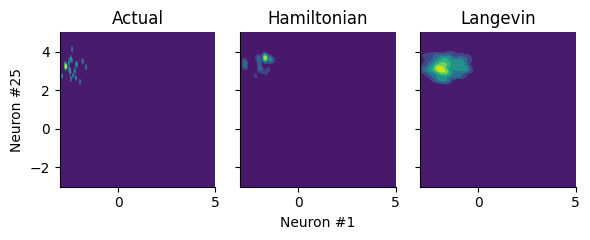

In [30]:
fig, ax = plt.subplots(1,3, figsize=(6, 2.5), sharey="all", sharex="all")
ax[1].contourf(U_gsm.x, U_gsm.x, U_gsm.density)
ax[1].set_title("Actual")
ax[2].contourf(U_nhmc.x, U_nhmc.x, U_nhmc.density)
ax[2].set_title("Hamiltonian")
ax[3].contourf(U_nlmc.x, U_nlmc.x, U_nlmc.density)
ax[3].set_title("Langevin")
ax[1].set_ylabel("Neuron #"*string(unit_idx[2]))
ax[2].set_xlabel("Neuron #"*string(unit_idx[1])) 
fig.tight_layout()

Hamiltonianネットワークの方が安定して事後分布を推定することができている．ToDo: 以下の記述．ここでは重みを設定したが， {cite:p}`Echeveste2020-sh`ではRNNにBPTTで重みを学習させている．動的な入力に対するサンプリング {cite:p}`Berkes2011-xj`．burn-inがなくなり効率良くサンプリングできる．

## Spikingニューラルネットワークにおけるサンプリング
前項で挙げた例は発火率モデルであったが，SNNにおいてサンプリングを実行する機構自体は考案されている．ToDo: 以下の記述．{cite:p}`Buesing2011-dm`{cite:p}`Masset2022-wh`{cite:p}`Zhang2022-bl`

## シナプスサンプリング
ここまでシナプス結合強度は変化せず，神経活動の変動によりサンプリングを行うというモデルについて考えてきた．一方で，シナプス結合強度自体が短時間で変動することによりベイズ推論を実行するというモデルがあり，**シナプスサンプリング(synaptic sampling)** と呼ばれる．ToDo: 以下の記述．{cite:p}`Kappel2015-kq`{cite:p}`Aitchison2021-wo`

## 参考文献
```{bibliography}
:filter: docname in docnames
```